# Pipeline for analyzing flow cytometry data

In [9]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [10]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180702_FB2Dtrip/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180702_FB2Dtrip/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180702_FB2Dtrip/Plate3/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180702_FB2Dtrip/Plate4/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180702_FB2Dtrip/Plate5/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180622_ZPMplantcomp/Plate2/')

date = '20180702'

allfiles = {}
strains = ['Plate1','Plate2','Plate3','Plate4','Plate5','Plate6']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [11]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [12]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

In [13]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['SSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['AmCyan-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['AmCyan-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats]


In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,10,1000)


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be remov

In [23]:
#Define the rows

Econcind = range(8)
Pconcind = range(12)

Econc = list()
Pconc = list()

for j in range(7):
    Econc.append(round(30*0.5**j,2))

for i in range(11):
    Pconc.append(round(100*0.5**i,2))

Px = [round(100*0.5**i,2) for i in range(11)]

Econc.append(0)
Pconc.append(0)
Px.append(0)

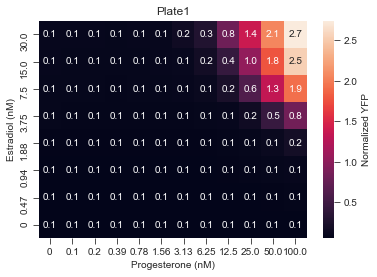

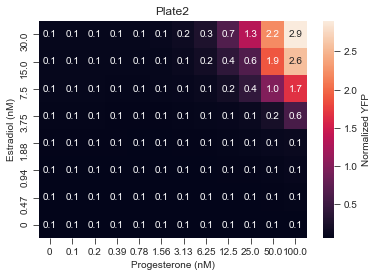

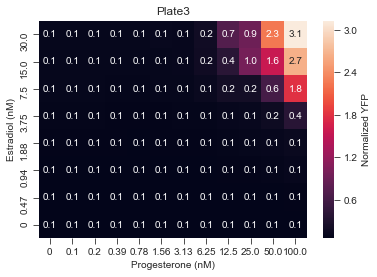

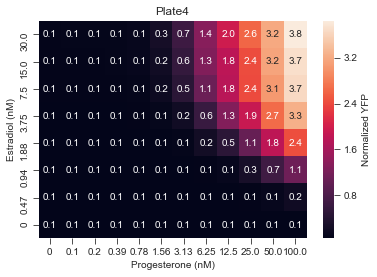

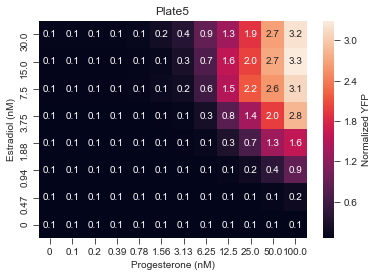

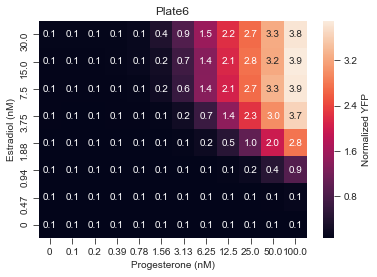

In [9]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].avg.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

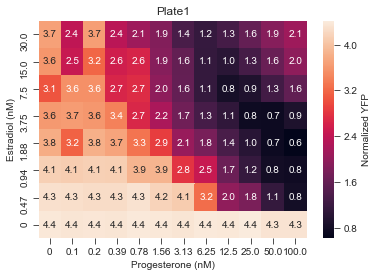

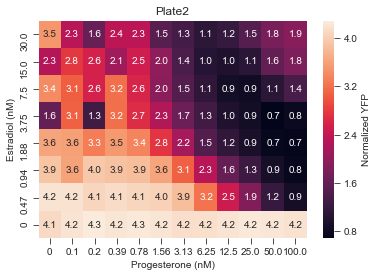

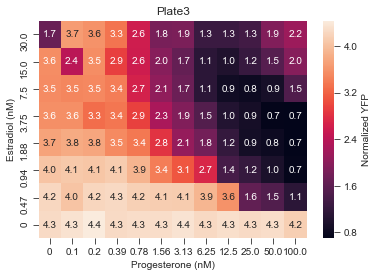

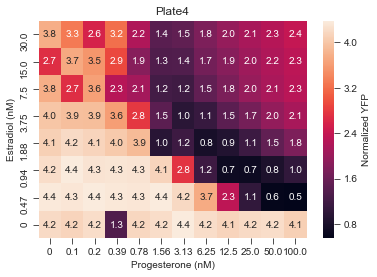

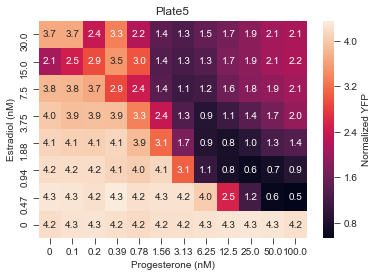

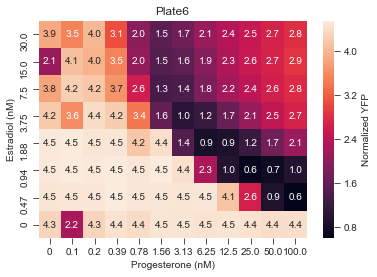

In [10]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].cv.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPCVheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

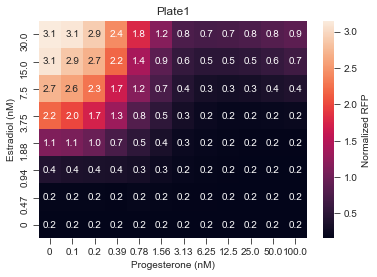

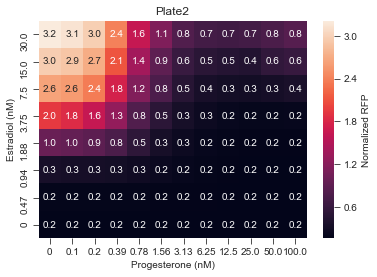

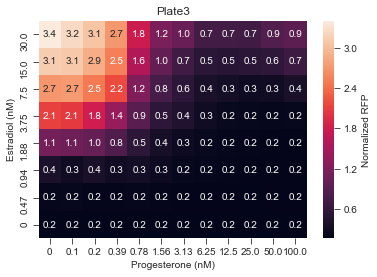

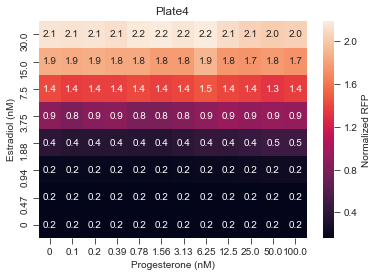

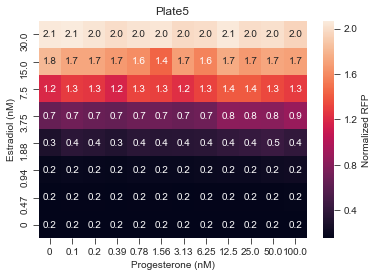

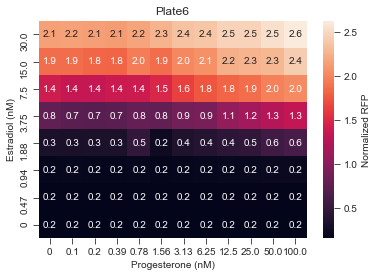

In [11]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

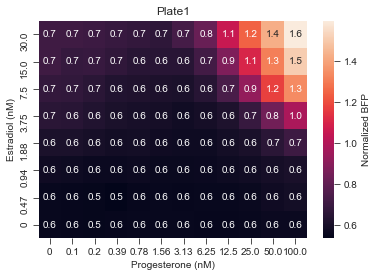

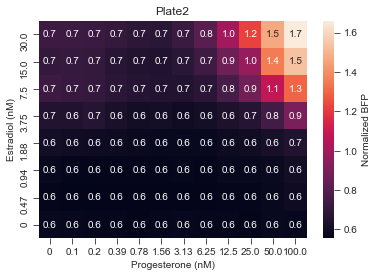

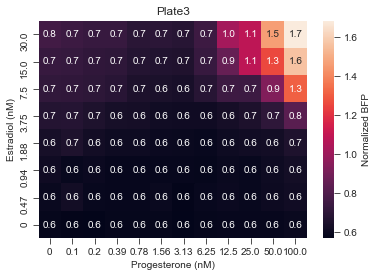

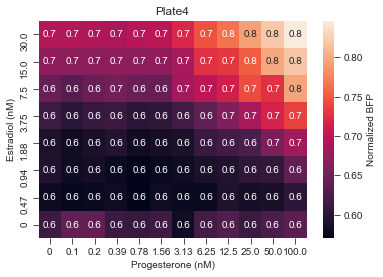

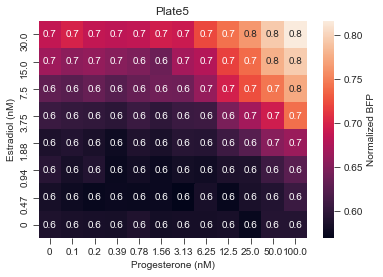

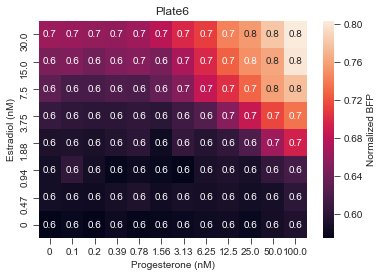

In [12]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

In [16]:
FITCclean = pd.DataFrame(index = rows, columns = cols)
logFITCclean = pd.DataFrame(index = rows, columns = cols)

for row in rows:
    for col in cols:
        try:
            FITCclean.loc[row,col] = cleandata(allplates['767t1'].loc[row,col].data['FITC-A'].values,100)
            logFITCclean.loc[row,col] = np.log10(cleandata(allplates['767t1'].loc[row,col].data['FITC-A'].values,100))
        except:
            continue

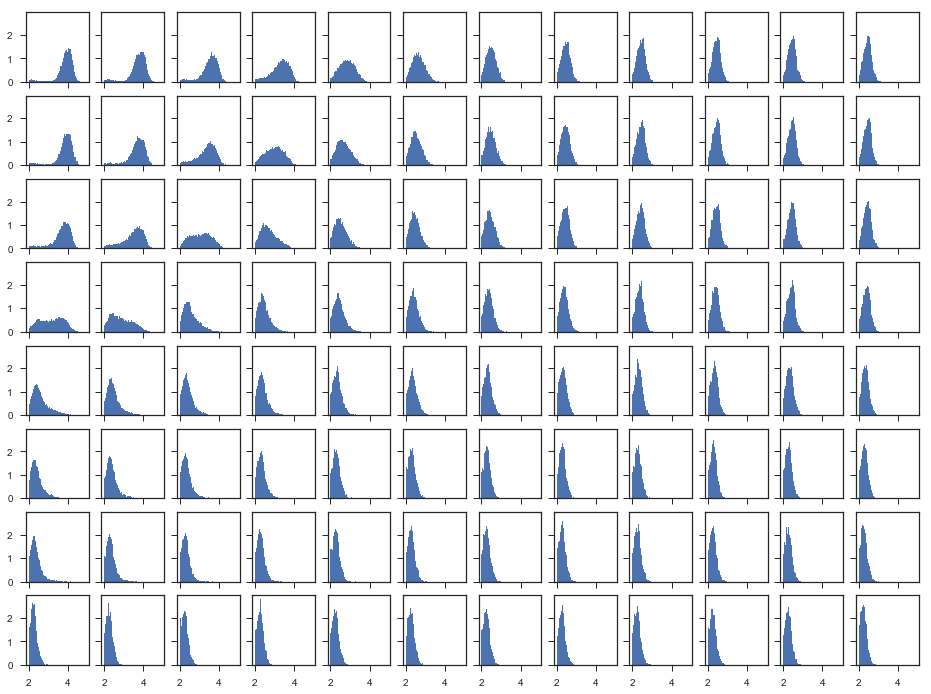

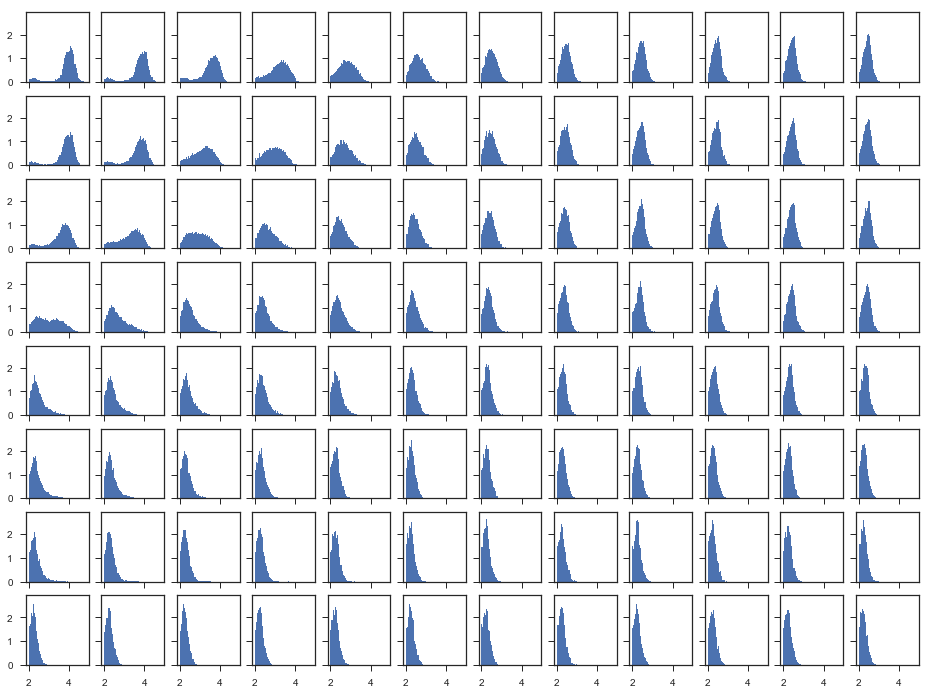

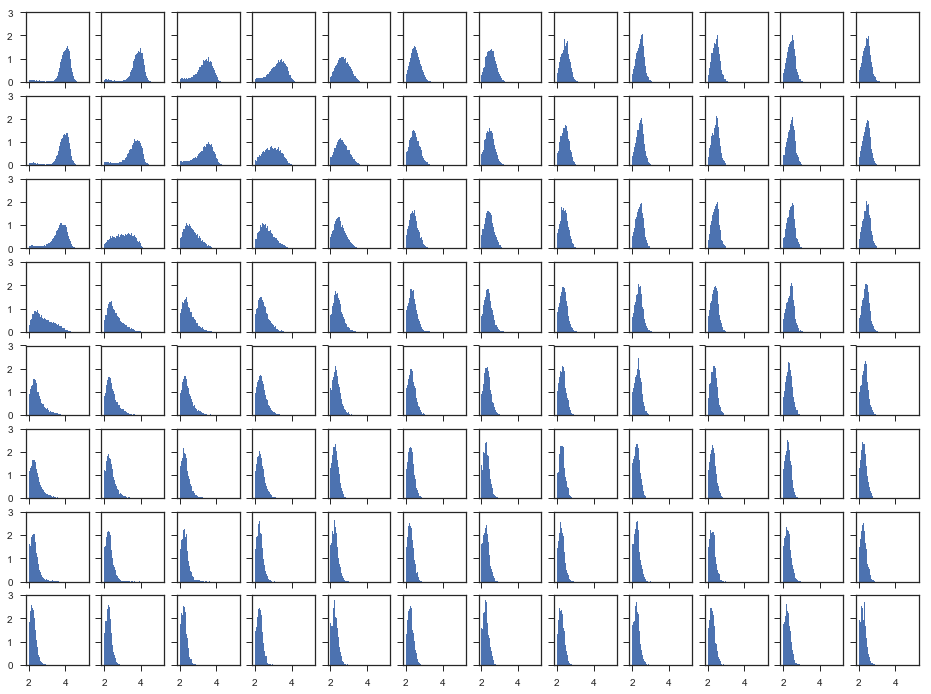

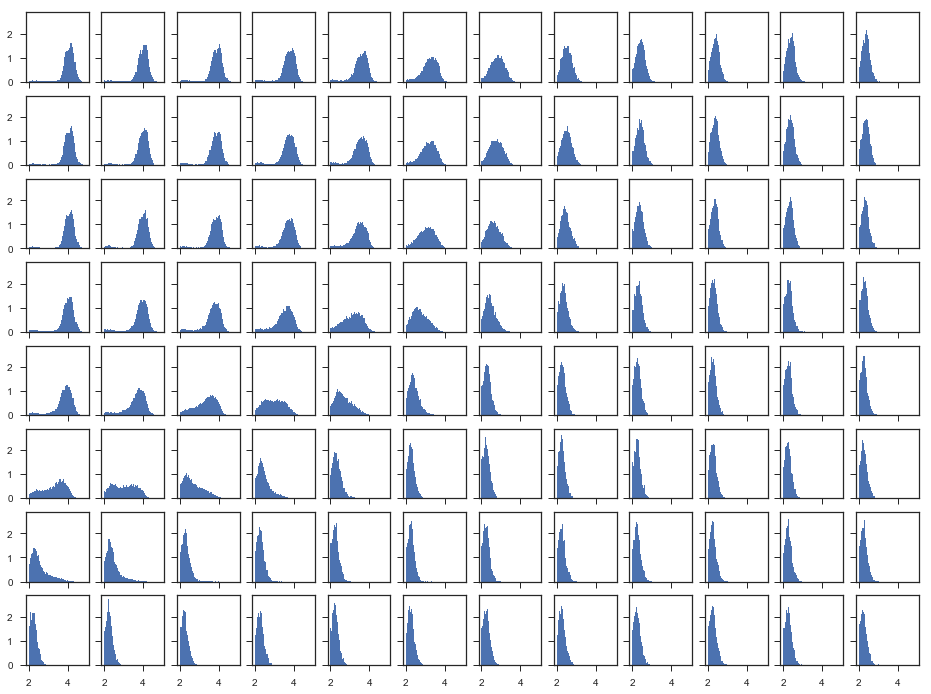

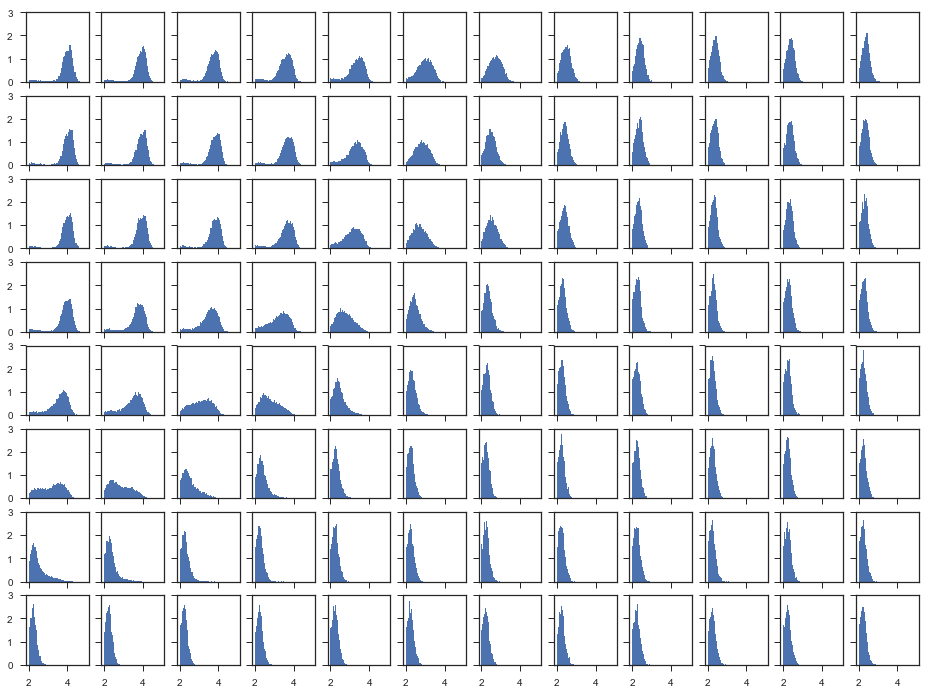

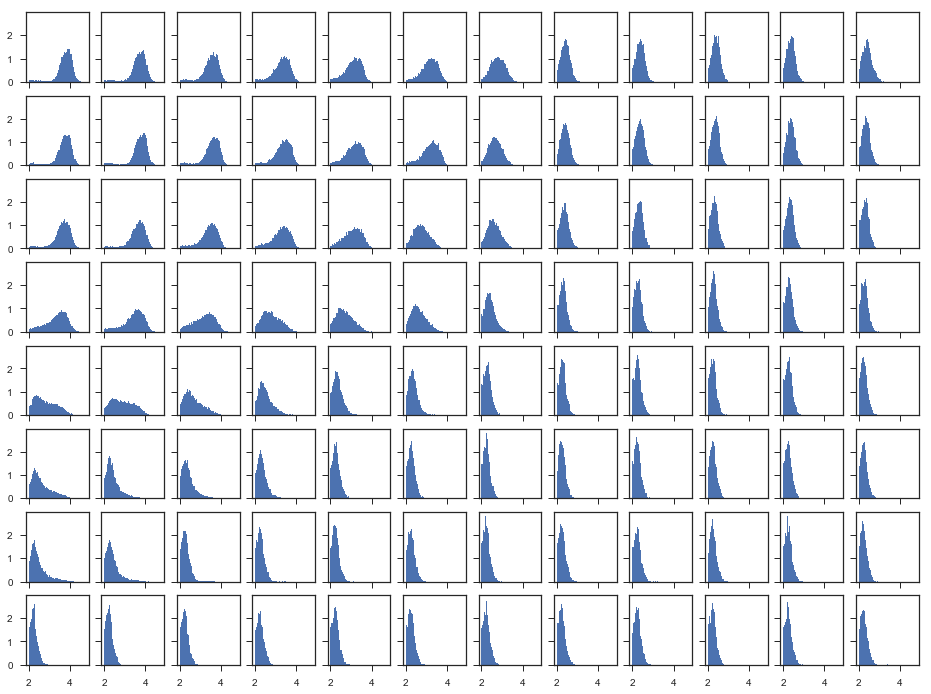

In [17]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=1)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [18]:
plt.set_cmap('plasma')

# Process data in arrays; take averages and standard deviations

In [24]:
#Average across the triplicate plates

CLFITCavg = pd.DataFrame(index = rows, columns = cols)
CLRFPavg = pd.DataFrame(index = rows, columns = cols)
CLBFPavg = pd.DataFrame(index = rows, columns = cols)

CLFITCstd = pd.DataFrame(index = rows, columns = cols)
CLRFPstd = pd.DataFrame(index = rows, columns = cols)
CLBFPstd = pd.DataFrame(index = rows, columns = cols)

OLFITCavg = pd.DataFrame(index = rows, columns = cols)
OLRFPavg = pd.DataFrame(index = rows, columns = cols)
OLBFPavg = pd.DataFrame(index = rows, columns = cols)

OLFITCstd = pd.DataFrame(index = rows, columns = cols)
OLRFPstd = pd.DataFrame(index = rows, columns = cols)
OLBFPstd = pd.DataFrame(index = rows, columns = cols)


for j, r in enumerate(rows):
    for i, c in enumerate(cols):
        CLFITCavg.set_value(r, c, np.mean([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate2'].med.iloc[j,i],FITCnorm['Plate3'].med.iloc[j,i]]))
        CLFITCstd.set_value(r, c, np.std([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate2'].med.iloc[j,i],FITCnorm['Plate3'].med.iloc[j,i]]))

        CLRFPavg.set_value(r, c, np.mean([RFPnorm['Plate1'].med.iloc[j,i],RFPnorm['Plate2'].med.iloc[j,i],RFPnorm['Plate3'].med.iloc[j,i]]))
        CLRFPstd.set_value(r, c, np.std([RFPnorm['Plate1'].med.iloc[j,i],RFPnorm['Plate2'].med.iloc[j,i],RFPnorm['Plate3'].med.iloc[j,i]]))

        CLBFPavg.set_value(r, c, np.mean([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate2'].med.iloc[j,i],BFPnorm['Plate3'].med.iloc[j,i]]))
        CLBFPstd.set_value(r, c, np.std([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate2'].med.iloc[j,i],BFPnorm['Plate3'].med.iloc[j,i]]))
        
        OLFITCavg.set_value(r, c, np.mean([FITCnorm['Plate4'].med.iloc[j,i],FITCnorm['Plate5'].med.iloc[j,i],FITCnorm['Plate6'].med.iloc[j,i]]))
        OLFITCstd.set_value(r, c, np.std([FITCnorm['Plate4'].med.iloc[j,i],FITCnorm['Plate5'].med.iloc[j,i],FITCnorm['Plate6'].med.iloc[j,i]]))
        
        OLRFPavg.set_value(r, c, np.mean([RFPnorm['Plate4'].med.iloc[j,i],RFPnorm['Plate5'].med.iloc[j,i],RFPnorm['Plate6'].med.iloc[j,i]]))
        OLRFPstd.set_value(r, c, np.std([RFPnorm['Plate4'].med.iloc[j,i],RFPnorm['Plate5'].med.iloc[j,i],RFPnorm['Plate6'].med.iloc[j,i]]))
        
        OLBFPavg.set_value(r, c, np.mean([BFPnorm['Plate4'].med.iloc[j,i],BFPnorm['Plate5'].med.iloc[j,i],BFPnorm['Plate6'].med.iloc[j,i]]))
        OLBFPstd.set_value(r, c, np.std([BFPnorm['Plate4'].med.iloc[j,i],BFPnorm['Plate5'].med.iloc[j,i],BFPnorm['Plate6'].med.iloc[j,i]]))
        

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or 

In [25]:
CLFITCcvavg = pd.DataFrame(index = rows, columns = cols)
CLRFPcvavg = pd.DataFrame(index = rows, columns = cols)
CLBFPcvavg = pd.DataFrame(index = rows, columns = cols)

CLFITCcvstd = pd.DataFrame(index = rows, columns = cols)
CLRFPcvstd = pd.DataFrame(index = rows, columns = cols)
CLBFPcvstd = pd.DataFrame(index = rows, columns = cols)

OLFITCcvavg = pd.DataFrame(index = rows, columns = cols)
OLRFPcvavg = pd.DataFrame(index = rows, columns = cols)
OLBFPcvavg = pd.DataFrame(index = rows, columns = cols)

OLFITCcvstd = pd.DataFrame(index = rows, columns = cols)
OLRFPcvstd = pd.DataFrame(index = rows, columns = cols)
OLBFPcvstd = pd.DataFrame(index = rows, columns = cols)


for j, r in enumerate(rows):
    for i, c in enumerate(cols):
        CLFITCcvavg.set_value(r, c, np.mean([FITCnorm['Plate1'].cv.iloc[j,i],FITCnorm['Plate2'].cv.iloc[j,i],FITCnorm['Plate3'].cv.iloc[j,i]]))
        CLFITCcvstd.set_value(r, c, np.std([FITCnorm['Plate1'].cv.iloc[j,i],FITCnorm['Plate2'].cv.iloc[j,i],FITCnorm['Plate3'].cv.iloc[j,i]]))

        CLRFPcvavg.set_value(r, c, np.mean([RFPnorm['Plate1'].cv.iloc[j,i],RFPnorm['Plate2'].cv.iloc[j,i],RFPnorm['Plate3'].cv.iloc[j,i]]))
        CLRFPcvstd.set_value(r, c, np.std([RFPnorm['Plate1'].cv.iloc[j,i],RFPnorm['Plate2'].cv.iloc[j,i],RFPnorm['Plate3'].cv.iloc[j,i]]))

        CLBFPcvavg.set_value(r, c, np.mean([BFPnorm['Plate1'].cv.iloc[j,i],BFPnorm['Plate2'].cv.iloc[j,i],BFPnorm['Plate3'].cv.iloc[j,i]]))
        CLBFPcvstd.set_value(r, c, np.std([BFPnorm['Plate1'].cv.iloc[j,i],BFPnorm['Plate2'].cv.iloc[j,i],BFPnorm['Plate3'].cv.iloc[j,i]]))
        
        OLFITCcvavg.set_value(r, c, np.mean([FITCnorm['Plate4'].cv.iloc[j,i],FITCnorm['Plate5'].cv.iloc[j,i],FITCnorm['Plate6'].cv.iloc[j,i]]))
        OLFITCcvstd.set_value(r, c, np.std([FITCnorm['Plate4'].cv.iloc[j,i],FITCnorm['Plate5'].cv.iloc[j,i],FITCnorm['Plate6'].cv.iloc[j,i]]))
        
        OLRFPcvavg.set_value(r, c, np.mean([RFPnorm['Plate4'].cv.iloc[j,i],RFPnorm['Plate5'].cv.iloc[j,i],RFPnorm['Plate6'].cv.iloc[j,i]]))
        OLRFPcvstd.set_value(r, c, np.std([RFPnorm['Plate4'].cv.iloc[j,i],RFPnorm['Plate5'].cv.iloc[j,i],RFPnorm['Plate6'].cv.iloc[j,i]]))
        
        OLBFPcvavg.set_value(r, c, np.mean([BFPnorm['Plate4'].cv.iloc[j,i],BFPnorm['Plate5'].cv.iloc[j,i],BFPnorm['Plate6'].cv.iloc[j,i]]))
        OLBFPcvstd.set_value(r, c, np.std([BFPnorm['Plate4'].cv.iloc[j,i],BFPnorm['Plate5'].cv.iloc[j,i],BFPnorm['Plate6'].cv.iloc[j,i]]))
        

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or 

In [15]:
#Save data
CLFITCavg.to_csv('CLYFPavg.csv')
CLRFPavg.to_csv('CLRFPavg.csv')
CLBFPavg.to_csv('CLBFPavg.csv')

CLFITCstd.to_csv('CLYFPstd.csv')
CLRFPstd.to_csv('CLRFPstd.csv')
CLBFPstd.to_csv('CLBFPstd.csv')

OLFITCavg.to_csv('OLYFPavg.csv')
OLRFPavg.to_csv('OLRFPavg.csv')
OLBFPavg.to_csv('OLBFPavg.csv')

OLFITCstd.to_csv('OLYFPstd.csv')
OLRFPstd.to_csv('OLRFPstd.csv')
OLBFPstd.to_csv('OLBFPstd.csv')

# Plot results

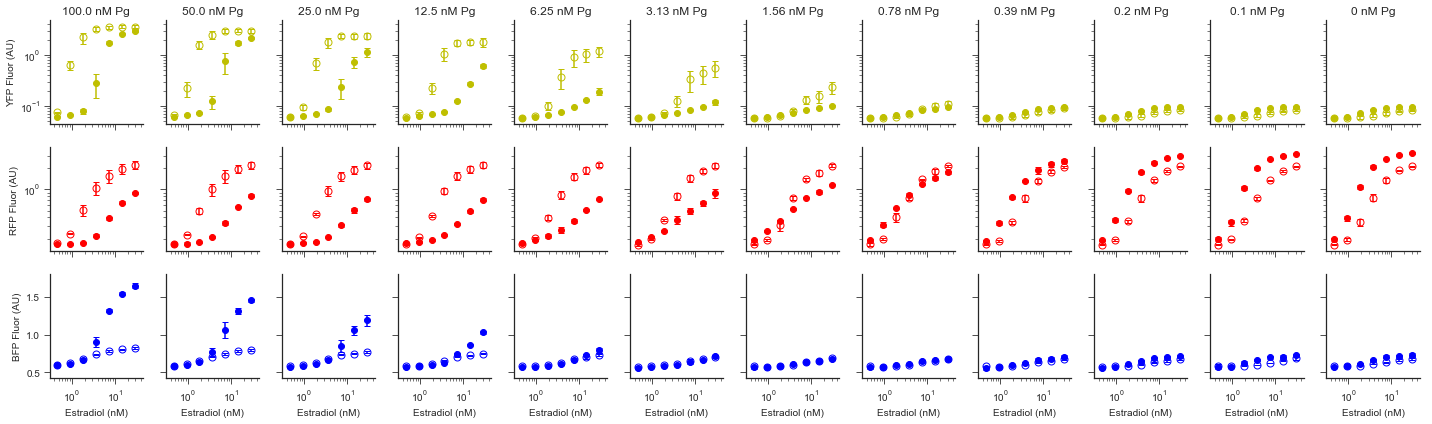

In [27]:
# Plot YFP, RFP, and CFP fluorescence as a function of E2 for each dose of Pg

fig, ax = plt.subplots(3, 12,sharex=True,sharey='row',figsize=(20,6))

for j in range(12):
    ax[0,j].errorbar(Econc,CLFITCavg.iloc[:,j],yerr=CLFITCstd.iloc[:,j],capsize=3,fmt ='o', color = 'y')
    ax[1,j].errorbar(Econc,CLRFPavg.iloc[:,j],yerr=CLRFPstd.iloc[:,j],capsize=3,fmt ='o', color = 'r')
    ax[2,j].errorbar(Econc,CLBFPavg.iloc[:,j],yerr=CLBFPstd.iloc[:,j],capsize=3,fmt ='o', color = 'b')
    
    ax[0,j].errorbar(Econc,OLFITCavg.iloc[:,j],yerr=OLFITCstd.iloc[:,j],capsize=3,fmt ='o', ms=7,mew=1,mec='y',mfc = 'none', color = 'y')
    ax[1,j].errorbar(Econc,OLRFPavg.iloc[:,j],yerr=OLRFPstd.iloc[:,j],capsize=3,fmt ='o', ms=7,mew=1,mec='r',mfc = 'none', color = 'r')
    ax[2,j].errorbar(Econc,OLBFPavg.iloc[:,j],yerr=OLBFPstd.iloc[:,j],capsize=3,fmt ='o', ms=7,mew=1,mec='b',mfc = 'none', color = 'b')
        

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('YFP Fluor (AU)')
ax[0,0].set_yscale('log')

ax[1,0].set_ylabel('RFP Fluor (AU)')
ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('BFP Fluor (AU)')
#ax[2,0].set_yscale('log')

for i in range(12):
    ax[2,i].set_xlabel('Estradiol (nM)')
    ax[2,i].set_xscale('log')
    ax[0,i].set_title(str(Pconc[i]) + ' nM Pg')

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'E2singleYRBcomparisonALL'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

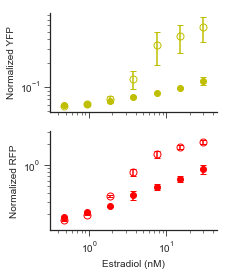

In [13]:
#Examine the E2 dose response at a single dose of Pg (3.13nM Pg)

fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(3,4))

ax[0].errorbar(Econc,CLFITCavg.iloc[:,5],yerr=CLFITCstd.iloc[:,5],capsize=3,fmt ='o', color = 'y')
ax[1].errorbar(Econc,CLRFPavg.iloc[:,5],yerr=CLRFPstd.iloc[:,5],capsize=3,fmt ='o', color = 'r')

ax[0].errorbar(Econc,OLFITCavg.iloc[:,5],yerr=OLFITCstd.iloc[:,5],capsize=3,fmt ='o', ms=7,mew=1,mec='y',mfc = 'none', color = 'y')
ax[1].errorbar(Econc,OLRFPavg.iloc[:,5],yerr=OLRFPstd.iloc[:,5],capsize=3,fmt ='o', ms=7,mew=1,mec='r',mfc = 'none', color = 'r')

ax[0].set_ylabel('Normalized YFP')
ax[0].set_yscale('log')

ax[1].set_ylabel('Normalized RFP')
ax[1].set_yscale('log')

ax[1].set_xlabel('Estradiol (nM)')
ax[1].set_xscale('log')
#ax[1].set_xticks(Econcind)
#ax[1].set_xticklabels(Econc[::-1],rotation = 60)
#ax[0,i].set_title('Pg = ' + Pconc[i+2])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'oneE2singleYRBcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

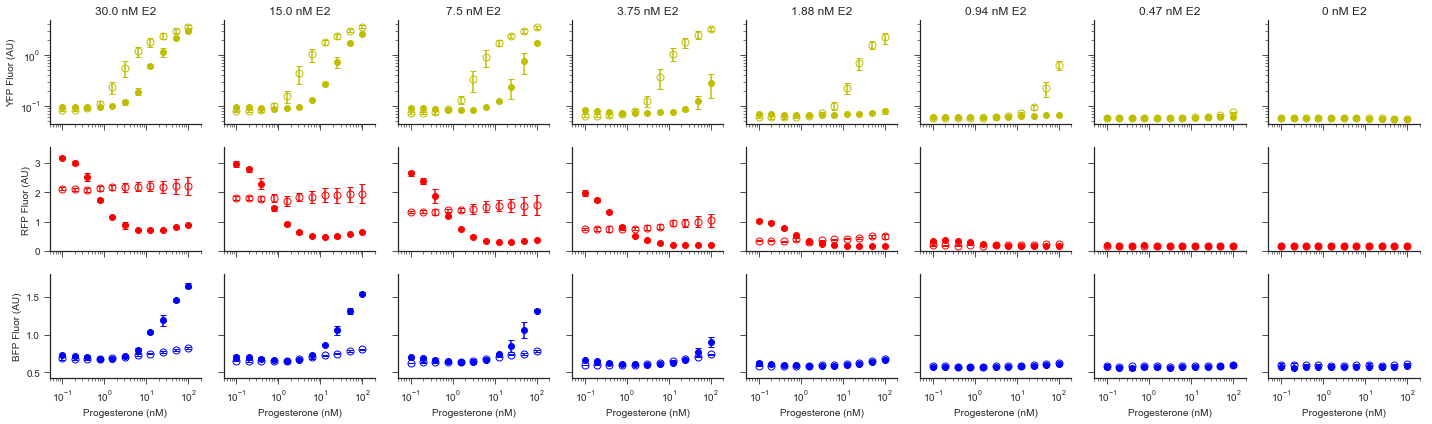

In [29]:
#Plot YFP, RFP, and CFP fluorescence as a function of Pg for each dose of E2

fig, ax = plt.subplots(3, 8,sharex=True,sharey='row',figsize=(20,6))

for j in range(8):
    ax[0,j].errorbar(Pconc,CLFITCavg.iloc[j,:],yerr=CLFITCstd.iloc[j,:],capsize=3,fmt ='o', color = 'y')
    ax[1,j].errorbar(Pconc,CLRFPavg.iloc[j,:],yerr=CLRFPstd.iloc[j,:],capsize=3,fmt ='o', color = 'r')
    ax[2,j].errorbar(Pconc,CLBFPavg.iloc[j,:],yerr=CLBFPstd.iloc[j,:],capsize=3,fmt ='o', color = 'b')
    
    ax[0,j].errorbar(Pconc,OLFITCavg.iloc[j,:],yerr=OLFITCstd.iloc[j,:],capsize=3,fmt ='o', ms=7,mew=1,mec='y',mfc = 'none', color = 'y')
    ax[1,j].errorbar(Pconc,OLRFPavg.iloc[j,:],yerr=OLRFPstd.iloc[j,:],capsize=3,fmt ='o', ms=7,mew=1,mec='r',mfc = 'none', color = 'r')
    ax[2,j].errorbar(Pconc,OLBFPavg.iloc[j,:],yerr=OLBFPstd.iloc[j,:],capsize=3,fmt ='o', ms=7,mew=1,mec='b',mfc = 'none', color = 'b')
    
#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('YFP Fluor (AU)')
ax[0,0].set_yscale('log')

ax[1,0].set_ylabel('RFP Fluor (AU)')
#ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('BFP Fluor (AU)')
#ax[2,0].set_yscale('log')

for i in range(8):
    ax[2,i].set_xlabel('Progesterone (nM)')
    ax[2,i].set_xscale('log')
    ax[0,i].set_title(str(Econc[i]) + ' nM E2')

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'PgsingleYRBcomparisonALL'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

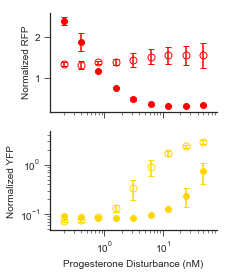

In [11]:
#Examine the Pg dose response at a single dose of E2 (7.5nM E2)

fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(3,4))

ax[1].errorbar(Pconc[1:10],CLFITCavg.iloc[2,1:10],yerr=CLFITCstd.iloc[2,1:10],capsize=3,fmt ='o', color = 'gold')
ax[0].errorbar(Pconc[1:10],CLRFPavg.iloc[2,1:10],yerr=CLRFPstd.iloc[2,1:10],capsize=3,fmt ='o', color = 'r')

ax[1].errorbar(Pconc[1:10],OLFITCavg.iloc[2,1:10],yerr=OLFITCstd.iloc[2,1:10],capsize=3,fmt ='o', ms=7,mew=1,mec='gold',mfc = 'none', color = 'gold')
ax[0].errorbar(Pconc[1:10],OLRFPavg.iloc[2,1:10],yerr=OLRFPstd.iloc[2,1:10],capsize=3,fmt ='o', ms=7,mew=1,mec='r',mfc = 'none', color = 'r')        

#ax[0,0].set_yscale('log')
ax[1].set_ylabel('Normalized YFP')
ax[1].set_yscale('log')

ax[0].set_ylabel('Normalized RFP')
#ax[1].set_yscale('log')

ax[1].set_xlabel('Progesterone Disturbance (nM)')
ax[1].set_xscale('log')
#ax[1].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'onePgsingleYRcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

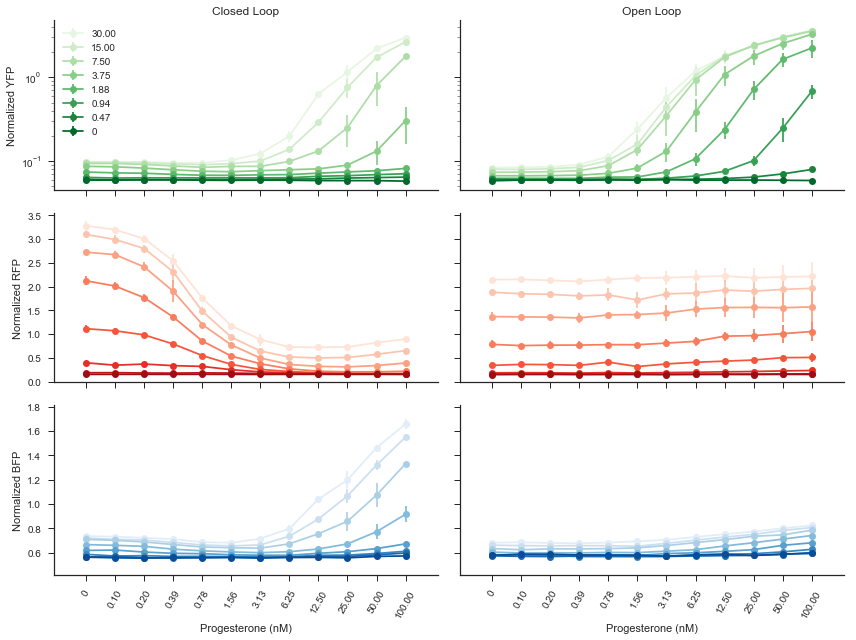

In [60]:
#Overlay all the dose responses on top of each other

fig, ax = plt.subplots(3, 2,sharex=True,sharey='row',figsize=(12,9))

Greens = sns.color_palette('Greens',8)
Reds = sns.color_palette('Reds',8)
Blues = sns.color_palette('Blues',8)

for i in range(8):
    #Plot YFP values
    ax[0,0].errorbar(Pconcind,CLFITCavg.iloc[i,::-1],yerr=CLFITCstd.iloc[i,::-1],fmt ='o-', color = Greens[i],label=Econc[i])
    ax[0,1].errorbar(Pconcind,OLFITCavg.iloc[i,::-1],yerr=OLFITCstd.iloc[i,::-1],fmt ='o-', color = Greens[i],label=Econc[i])

    #Plot RFP values
    ax[1,0].errorbar(Pconcind,CLRFPavg.iloc[i,::-1],yerr=CLRFPstd.iloc[i,::-1],fmt ='o-', color = Reds[i], label=Econc[i])
    ax[1,1].errorbar(Pconcind,OLRFPavg.iloc[i,::-1],yerr=OLRFPstd.iloc[i,::-1],fmt ='o-', color = Reds[i], label=Econc[i])
    
    #Plot BFP values
    ax[2,0].errorbar(Pconcind,CLBFPavg.iloc[i,::-1],yerr=CLBFPstd.iloc[i,::-1],fmt ='o-', color = Blues[i], label=Econc[i])
    ax[2,1].errorbar(Pconcind,OLBFPavg.iloc[i,::-1],yerr=OLBFPstd.iloc[i,::-1],fmt ='o-', color = Blues[i], label=Econc[i])

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[1,0].set_ylabel('Normalized RFP')
#ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

ax[2,0].set_xlabel('Progesterone (nM)')
ax[2,0].set_xticks(Pconcind)
ax[2,0].set_xticklabels(Pconc[::-1],rotation = 60)

ax[2,1].set_xlabel('Progesterone (nM)')
ax[2,1].set_xticks(Pconcind)
ax[2,1].set_xticklabels(Pconc[::-1],rotation = 60)

ax[0,0].set_title('Closed Loop')
ax[0,1].set_title('Open Loop')


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'YRBcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()